<a href="https://colab.research.google.com/github/avilaJorge/CSE253_FinalProject/blob/master/DeepFakeDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp *.py /content/drive/My\ Drive/CSE253/PA5/PyFiles
!cp *.ipynb /content/drive/My\ Drive/CSE253/PA5/PyFiles

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [1]:
%run deepfake_dataloader.py
%run utils.py

In [2]:
# imports pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Numpy, Matplotlib, and PIL
import numpy as np
import matplotlib.pyplot as plt

# K-means import
# !pip install pykeops
from pykeops.torch import LazyTensor
# !pip install kmeans-pytorch
from kmeans_pytorch import kmeans

# general imports
import pprint
from PIL import Image

# My imports
from deepfake_dataloader import get_dataloaders
from models import LinearRegression, save_model, SVM, KMeans
from utils import RunningAverage
from train import train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def show_misclassified(eval_info_):
    predictions = torch.FloatTensor(eval_info_['predics'])
    accuracies  = torch.IntTensor(eval_info_['accuracy'])
    img_classes = torch.FloatTensor(eval_info_['img_class'])
    img_data    = eval_info_['img_data']
    img_paths   = [np.char.decode(np.ndarray.tostring(s.numpy())) for s in eval_info_['img_paths']]

    lbr = (img_classes == origin_dataset['lsun_bedrooms']).nonzero()
    lcr = (img_classes == origin_dataset['lsun_cars']).nonzero()
    lct = (img_classes == origin_dataset['lsun_cats']).nonzero()
    lch = (img_classes == origin_dataset['lsun_churches']).nonzero()
    sbr = (img_classes == origin_dataset['stylegan1_bedrooms']).nonzero()
    scr = (img_classes == origin_dataset['stylegan2_cars']).nonzero()
    sct = (img_classes == origin_dataset['stylegan2_cats']).nonzero()
    sch = (img_classes == origin_dataset['stylegan2_churches']).nonzero()
    dsets = [(lbr, sbr), (lcr, scr), (lct, sct), (lch, sch)]

    count = 0
    for d in dsets:

        d = (d[0].squeeze(-1), d[1].squeeze(-1))
        pred = (predictions[d[0]].squeeze(-1), predictions[d[1]].squeeze(-1))
        accs = (accuracies[d[0]].squeeze(-1), accuracies[d[1]].squeeze(-1))
        
        # Flip 0s and 1s to get misclassified images
        mist = (
            (accs[0].squeeze(-1) == 0).nonzero().squeeze(-1), 
            (accs[1].squeeze(-1) == 0).nonzero().squeeze(-1)
        )
        
        
        accs = (accs[0][:] * 0, accs[1][:] * float('inf'))
            
        accs[0][mist[0]] = 1 
        accs[1][mist[1]] = 1
        
        pred = (pred[0][:] * accs[0][:], pred[1][:] * accs[1][:])
        
        idx  = (d[0][pred[0].argmax()], d[1][pred[1].argmin()])
        
        pr = (predictions[idx[0]], predictions[idx[1]])
        pr_str = ("{:.2e}".format(pr[0]), "{:.2e}".format(pr[1]))
            
        data = (img_data[idx[0]], img_data[idx[1]])
        d_s  = (origin_dataset[img_classes[idx[0]].item()], origin_dataset[img_classes[idx[1]].item()])
        pil_img = (Image.open(str(img_paths[idx[0]])), Image.open(str(img_paths[idx[1]])))
        pil_img = (pil_img[0].resize((256, 256)), pil_img[1].resize((256, 256)))

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='col',
                                gridspec_kw={'hspace': 1, 'wspace': 0.15, 'width_ratios': [1, 2, 1, 2]},
                                figsize=(30, 5))

        ax1.axis('off')
        ax3.axis('off')

        font_size = 26
        axis_size = 20
        ax1.set_title(d_s[0], size=font_size)
        ax3.set_title(d_s[1], size=font_size)
        ax2.set_title('1D Power Spectrum, p[fake]=%s' % pr_str[0], size=font_size)
        ax4.set_title('1D Power Spectrum, p[fake]=%s' % pr_str[1], size=font_size)

        ax1.imshow(pil_img[0])
        ax3.imshow(pil_img[1])

        ax2.plot(data[0].squeeze(0).cpu().numpy())
        ax2.set_xlabel('Spatial Frequency', fontsize=axis_size)
        ax2.set_ylabel('Power Spectrum',    fontsize=axis_size)
        ax4.plot(data[1].squeeze(0).cpu().numpy())
        ax4.set_xlabel('Spatial Frequency', fontsize=axis_size)
        ax4.set_ylabel('Power Spectrum',    fontsize=axis_size)

        plt.savefig('./misclassified_' + str(count) + '.jpg')
        count += 1
        plt.show()

In [4]:
trn_dl, val_dl, tst_dl = get_dataloaders(
    dataset=DeepFakeHDF5Dataset(hdf5_path='/home/jupyter/CSE253_FinalProject/LSUN_BCCC_256.hdf5'),
    batch_size=128,
    num_workers=16
    )

origin_dataset = {
    'lsun_bedrooms': 0, 
    'lsun_cars': 1, 
    'lsun_cats': 2, 
    'lsun_churches': 3, 
    'stylegan1_bedrooms': 4, 
    'stylegan2_cars': 5, 
    'stylegan2_cats': 6, 
    'stylegan2_churches': 7, 
    0: 'lsun_bedrooms', 
    1: 'lsun_cars', 
    2: 'lsun_cats', 
    3: 'lsun_churches', 
    4: 'stylegan1_bedrooms', 
    5: 'stylegan2_cars', 
    6: 'stylegan2_cats', 
    7: 'stylegan2_churches'
}

In [5]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-2
in_vec_len   = 182                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
load_model   = False
model_name   = 'LogisticRegressionModel'
path         = '/home/jupyter/CSE253_FinalProject/Logistic_Regression'

lr_model = LinearRegression(in_vec_len).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

In [ ]:
train_losses, valid_losses = train(lr_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   num_epochs=num_epochs,
                                   predicter=torch.nn.Sigmoid())

In [ ]:
epochs = range(1, len(train_losses) + 1)
epoch_ticks = [i if i % 5 == 0 else 0 for i in epochs]
    
plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, valid_losses, label='Validation loss')
plt.legend()
plt.title('Learning Curves for Logistic Regression\nlr=1e-2, weight_decay=1e-3, momentum=0.9')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.savefig('lr_train.jpg', dpi=300)
plt.show()


Validation Loss:  0.3963
Validation accuracy: 82.3250%


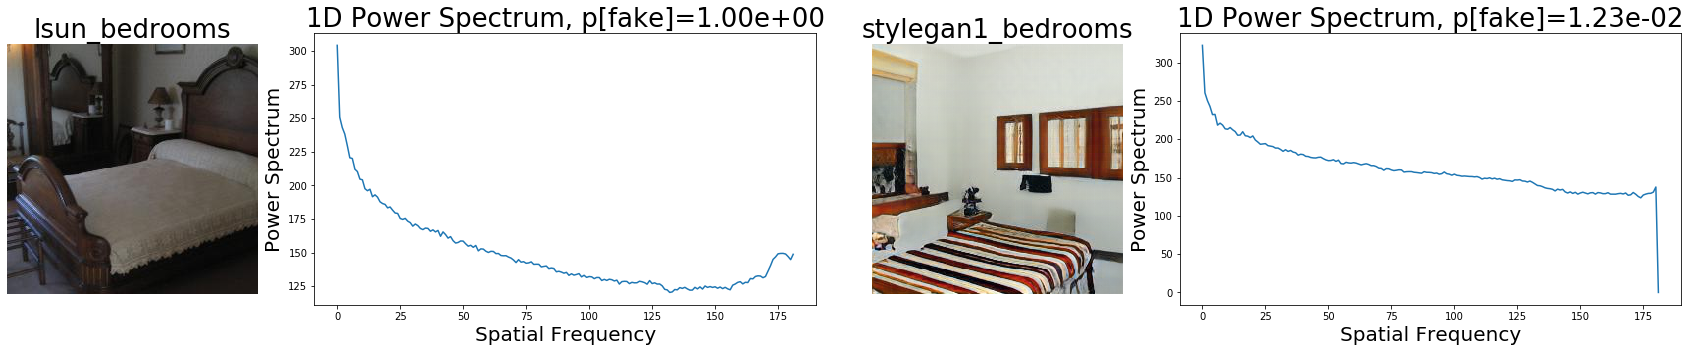

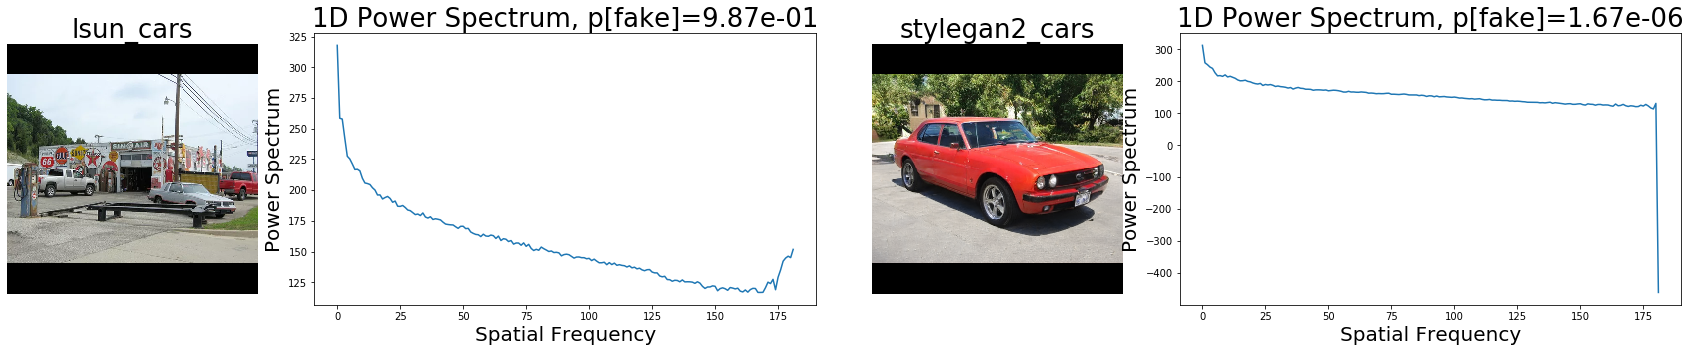

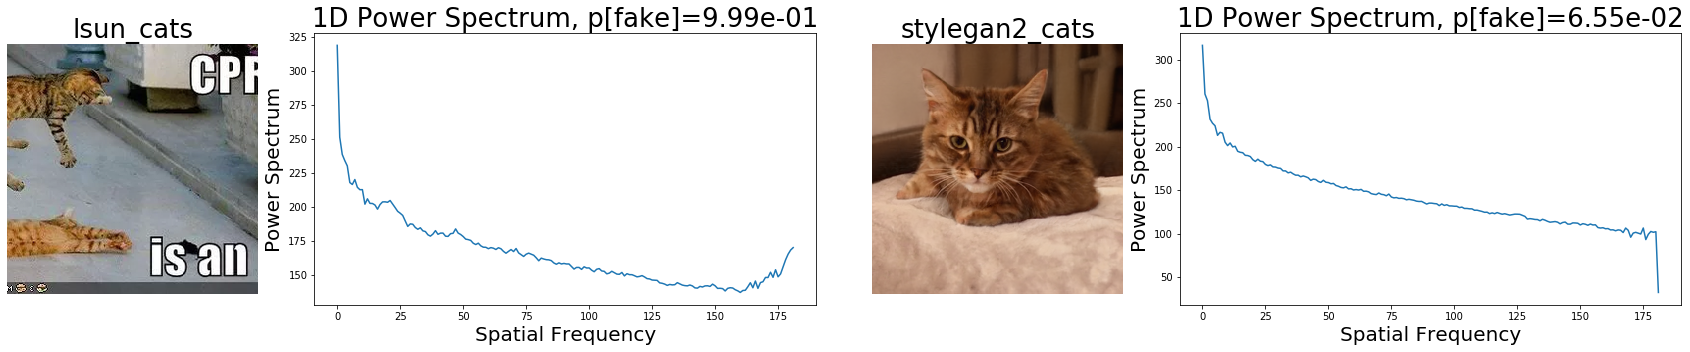

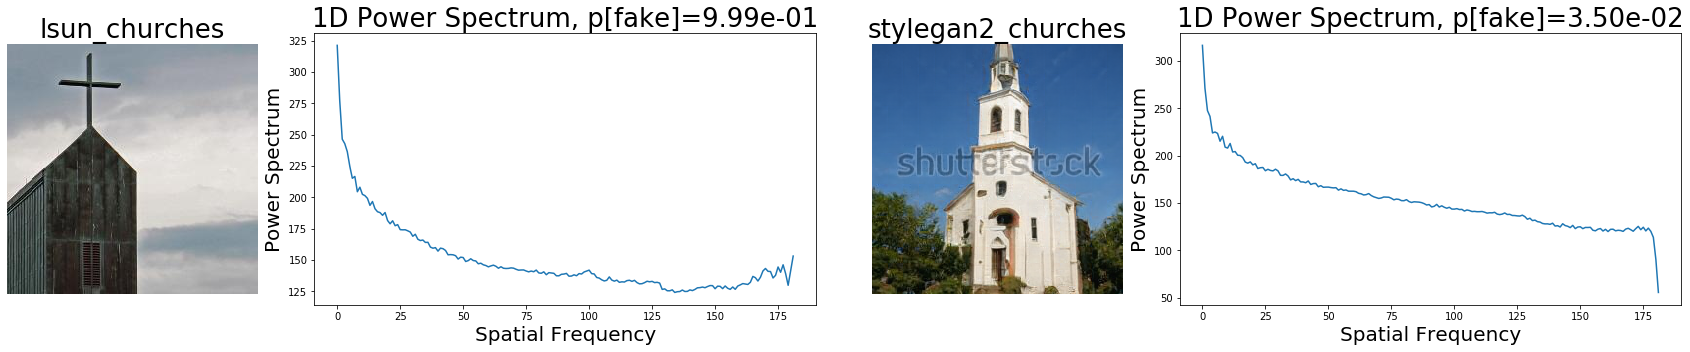

In [6]:
lr_model.load_state_dict(torch.load('/home/jupyter/CSE253_FinalProject/Logistic_Regression/decoder-Best-LogisticRegressionModel-03_18_23_03.ckpt'))

test_losses = []
eval_info_  = {}
evaluate(lr_model,
         optimizer,
         criterion,
         0,
         tst_dl,
         test_losses,
         "",
         "",
         acc_thresh=0.5,
         eval_info=eval_info_,
         predicter=torch.nn.Sigmoid(),
         validation=False)

show_misclassified(eval_info_)

In [7]:
trn_dl, val_dl, tst_dl = get_dataloaders(
    dataset=DeepFakeHDF5Dataset_SVM(
                                hdf5_path='/home/jupyter/CSE253_FinalProject/LSUN_BCCC_256.hdf5'
    )
)

In [9]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-2
load_model   = False
model_name   = 'SVMModel'
path         = '/content/SVM_Model'

svm_model = SVM(in_vec_len).to(device)
criterion = torch.nn.SoftMarginLoss()
optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

def svm_lbls(T):
    T[torch.nonzero((T < 0.0))] = 0
    return T

In [ ]:

train_losses, valid_losses = train(svm_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   acc_thresh=0.0,
                                   label_transform=svm_lbls,
                                   predicter=nn.Tanh())

Validation Loss:  0.4313
Validation accuracy: 79.1062%


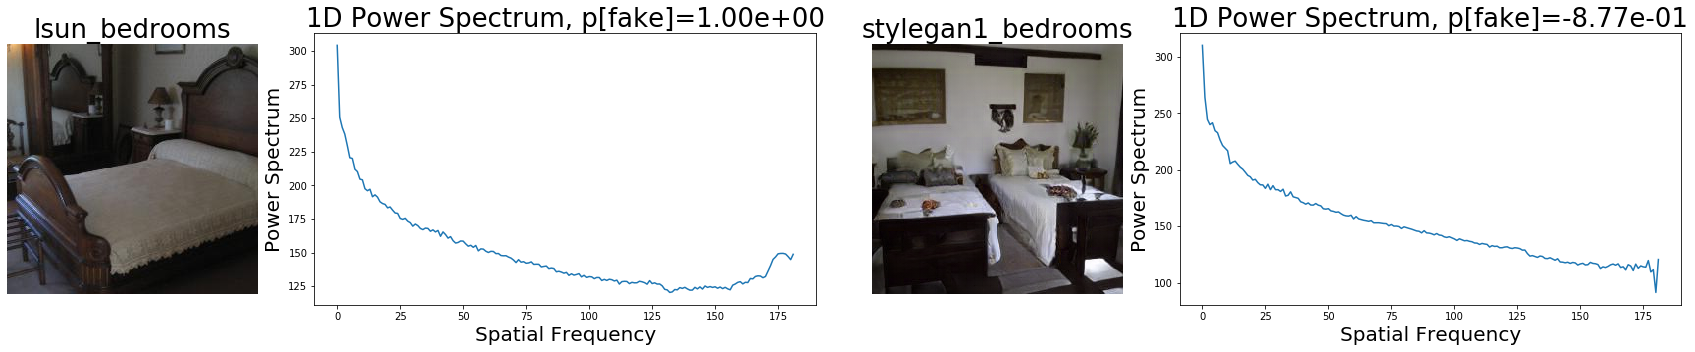

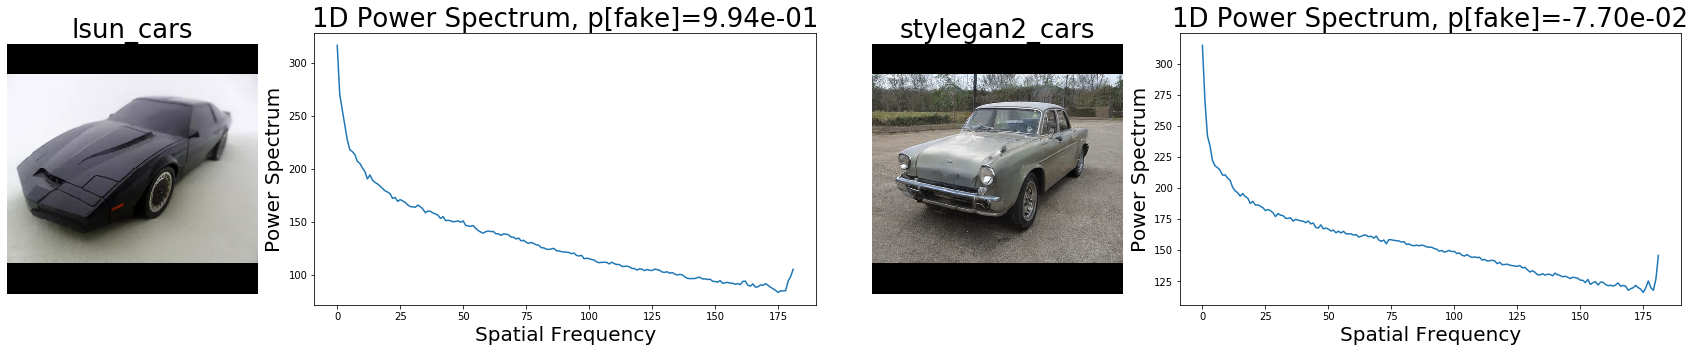

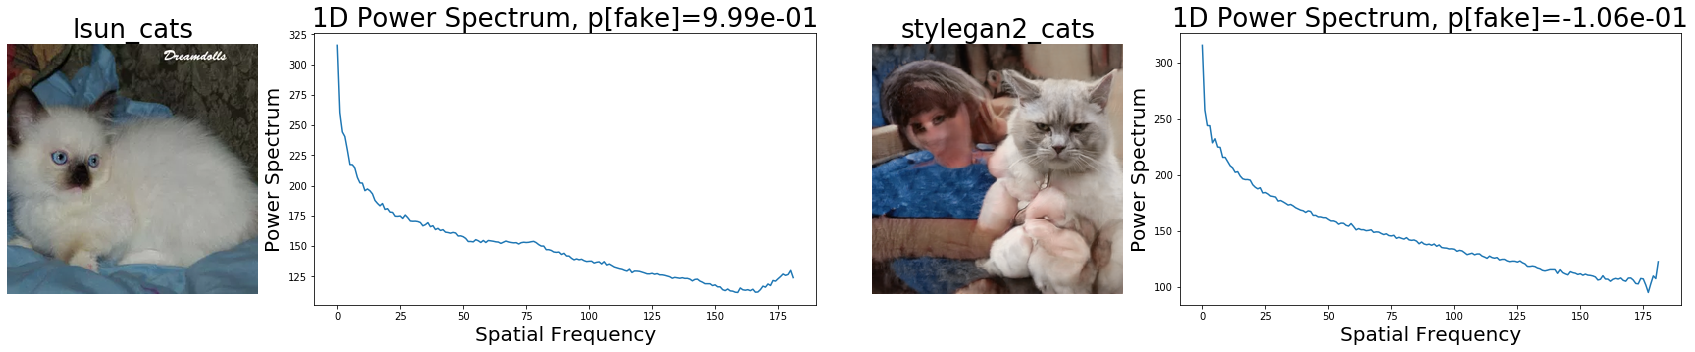

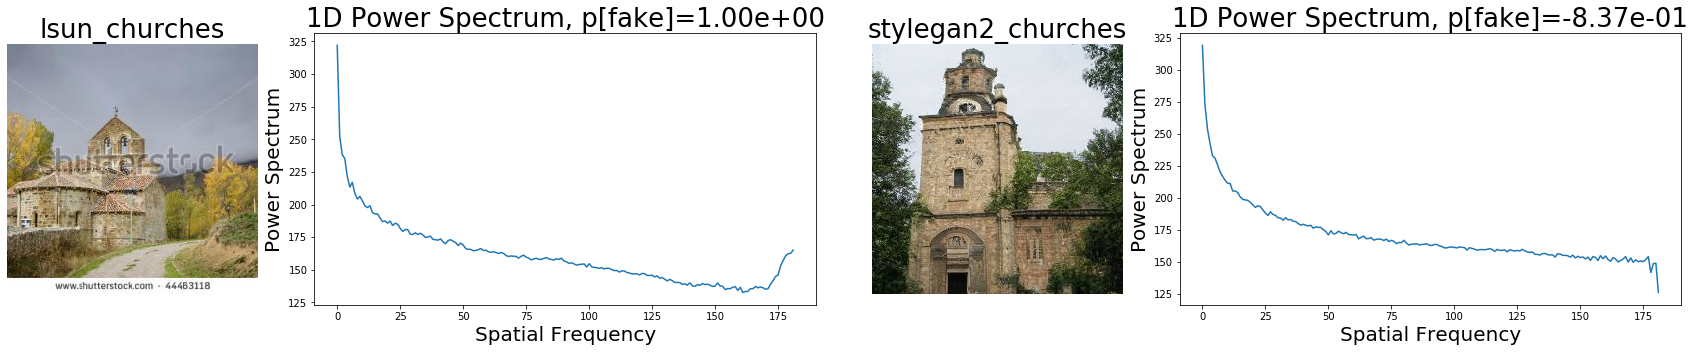

In [12]:
svm_model.load_state_dict(torch.load('/home/jupyter/CSE253_FinalProject/SVM_Model/decoder-Best-SVMModel-03_14_07_18.ckpt'))

test_losses = []
eval_info_  = {}
evaluate(svm_model,
         optimizer,
         criterion,
         0,
         tst_dl,
         test_losses,
         "",
         "",
         acc_thresh=0.0,
         eval_info=eval_info_,
         label_transform=svm_lbls,
         predicter=nn.Tanh(),
         validation=False)

show_misclassified(eval_info_)

In [ ]:
epochs = range(1, len(train_losses) + 1)
epoch_ticks = [i if i % 5 == 0 else 0 for i in epochs]
    
# plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, valid_losses, label='Validation loss')
plt.legend()
plt.title('Learning Curves for SVM\nlr=1e-2, weight_decay=1e-3, momentum=0.9')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.savefig("svm_train.jpg", dpi=300)
plt.show()

In [ ]:
full_dataloader = get_dataloaders(dataset=DeepFakeHDF5Dataset(), full_dataset=True)

In [ ]:
(x, y) = next(iter(full_dataloader))
print(x.shape)

In [ ]:
# Manual Standardization
from models import KMeans
mu = torch.mean(x, dim=1).unsqueeze(-1)
std = 1
X = (x.sub(other=mu))/std
cl, c = KMeans().run(X, K=2, Niter=50)

In [ ]:
print(cl.size())
print(c.size())
y = y.squeeze(-1).long()
print(y.size())
print(cl)
print(y)
sub = (cl - y)
print(sub)
print(sub.size())
print(cl == y)
accuracy = 1 - torch.mean((cl == y).float())
print("Accuracy: %f or %f " % (accuracy, (1-accuracy)))

In [ ]:
# data
(x, y) = next(iter(full_dataloader))
data_size, dims, num_clusters = x.size(0), 2, 2
mu = torch.mean(x, dim=1).unsqueeze(-1)
std = 1
X = (x.sub(other=mu))/std
# kmeans
cluster_ids_x, cluster_centers = kmeans(
    X=X, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
)

In [ ]:

print(cluster_ids_x.size())
print(cluster_ids_x)
y = y.squeeze(-1).long()
accuracy = torch.mean((cluster_ids_x == y).float())
print("Accuracy: %f or %f " % (accuracy, (1-accuracy)))

In [ ]:
from sklearn.cluster import KMeans
k = 2
kmeans = KMeans(n_clusters=k)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
Y = y.squeeze(-1).numpy()
print(Y.shape)
print(labels.shape)
res =labels+Y
cont=0
print(res.shape)
for z in range(len(res)):
    if res[z] == 1:
        cont+=1
print("Average KM: " + str(1-cont/len(res)) + " or " + str(cont/len(res)))